#### included WOE data and data dictionary

In [4]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import importlib
import numpy as np
import lightgbm as lgb

from tqdm import tqdm, tqdm_notebook
import sys

from _utilities import performance_eval as p_eval
from _utilities import performance_eval_v2 as p_eval2
from _utilities import woe

from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None ## pd warning

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
attrs_thin=pd.read_csv('model_results/thin_attr_dict_final_candidate.csv')
attrs_thick=pd.read_csv('model_results/thick_attr_dict_final_candidate.csv')
attrs_comibine=pd.concat([attrs_thin,attrs_thick],axis=0)
attrs_comibine.drop_duplicates('field_name',inplace=True)

### 2 read data

In [6]:
## this is the location saved the data
base_df=pd.read_parquet('model_data/model_scoring_df_v1_2.parquet.gzip')

In [7]:
base_df.groupby(['thin_thick']).size()

thin_thick
0    3181037
1     344489
dtype: int64

### 3 score

In [8]:
import pickle

file_name2='./model_results/thin_model_file_v12.p' 
thin_model=pickle.load(open(file_name2,'rb'))

file_name4='./model_results/thick_model_file_v12.p' 
thick_model=pickle.load(open(file_name4,'rb'))

In [9]:
model_attrs=list(set(thin_model.feature_name()+thick_model.feature_name()))
print(len(model_attrs))

55


In [10]:
### fix special### duplicate renamed attributes 
for aa in model_attrs:
    if aa[0:2]!='TB':
        old_name='premier_v1_2_'+aa.lower()
    else:
        old_name='trended3d_'+aa.lower()
        
    print(old_name,aa)    
    base_df[aa]=base_df[old_name]


    
attrs_dict=attrs_comibine[attrs_comibine['description'].isin(model_attrs)]

def fix_special(a_dict,df):
    i=0
    for attr in a_dict:
        i=i+1
        df.loc[df[attr]>a_dict[attr],attr]=np.nan
    print('#processed:',i)

attr_dd=dict(zip(attrs_dict['description'],attrs_dict['max']))

fix_special(attr_dd,base_df)

   
### score
base_df['thin_pred']=thin_model.predict(base_df[thin_model.feature_name()])
base_df['thick_pred']=thick_model.predict(base_df[thick_model.feature_name()])

base_df['model_pred']=np.where(base_df['thin_thick']==1, base_df['thin_pred'], base_df['thick_pred'])

premier_v1_2_alm6280 ALM6280
premier_v1_2_all7120 ALL7120
premier_v1_2_pil6200 PIL6200
premier_v1_2_all7938 ALL7938
premier_v1_2_all7340 ALL7340
premier_v1_2_bcc5620 BCC5620
trended3d_tbca3631 TBCA3631
trended3d_tbca3282 TBCA3282
premier_v1_2_iqt9420 IQT9420
premier_v1_2_all8152 ALL8152
trended3d_tbcc4260 TBCC4260
premier_v1_2_iqt9536 IQT9536
premier_v1_2_all7937 ALL7937
premier_v1_2_reh7120 REH7120
premier_v1_2_iqb9540 IQB9540
premier_v1_2_brc7150 BRC7150
premier_v1_2_iqt9510 IQT9510
premier_v1_2_alm6209 ALM6209
trended3d_tbcc4210 TBCC4210
premier_v1_2_brc5620 BRC5620
premier_v1_2_bcc7800 BCC7800
trended3d_tbcc2351 TBCC2351
premier_v1_2_iqt9427 IQT9427
premier_v1_2_all7936 ALL7936
premier_v1_2_alm6200 ALM6200
trended3d_tbca3275 TBCA3275
premier_v1_2_all8164 ALL8164
premier_v1_2_bca8370 BCA8370
trended3d_tbcc2502 TBCC2502
trended3d_tbca3629 TBCA3629
trended3d_tbca3274 TBCA3274
premier_v1_2_all8160 ALL8160
trended3d_tbca2527 TBCA2527
premier_v1_2_alm5074 ALM5074
premier_v1_2_all2001 ALL

In [11]:
### seperate samples into train oot back_test
base_train=base_df[(base_df.month_start>=201701)&(base_df.month_start<=201802)]
oot_test=base_df[base_df.month_start>=201803]
back_test=base_df[base_df.month_start<201701]

### 4-1 Thin PDP

In [13]:
thin_base=base_train[base_train.thin_thick==1]

In [20]:
df_check=thin_base
print(len(thin_base))
p_eval.model_score_eval(df_check['24_month_bad90_flag'],df_check['model_pred'],df_check['vantage_v3_score'],decile=10,display=0)

243253
model_pred AUC: 0.75705  KS: 37.7
vantage_v3_score AUC: 0.71094  KS: 31.9  #score missing: 0


In [16]:
print(len(thin_model.feature_name()))
np.array(thin_model.feature_name())

30


array(['TBCA2527', 'IQT9420', 'TBCA3631', 'ALL7120', 'ALM6209', 'ALL4520',
       'IQT9510', 'REH7120', 'BRC5620', 'TBCA3379', 'TBCC3351', 'ALL8370',
       'IQF9510', 'ALM5074', 'TBCC2502', 'ALL7937', 'ALL2001', 'IQT9536',
       'TBCA3274', 'TBCA3282', 'BCC7800', 'IQB9540', 'ALL7116', 'ALL8152',
       'TBCC4210', 'PIL6200', 'BRC7150', 'IQT9425', 'TBCA3629',
       'TBCC4260'], dtype='<U8')

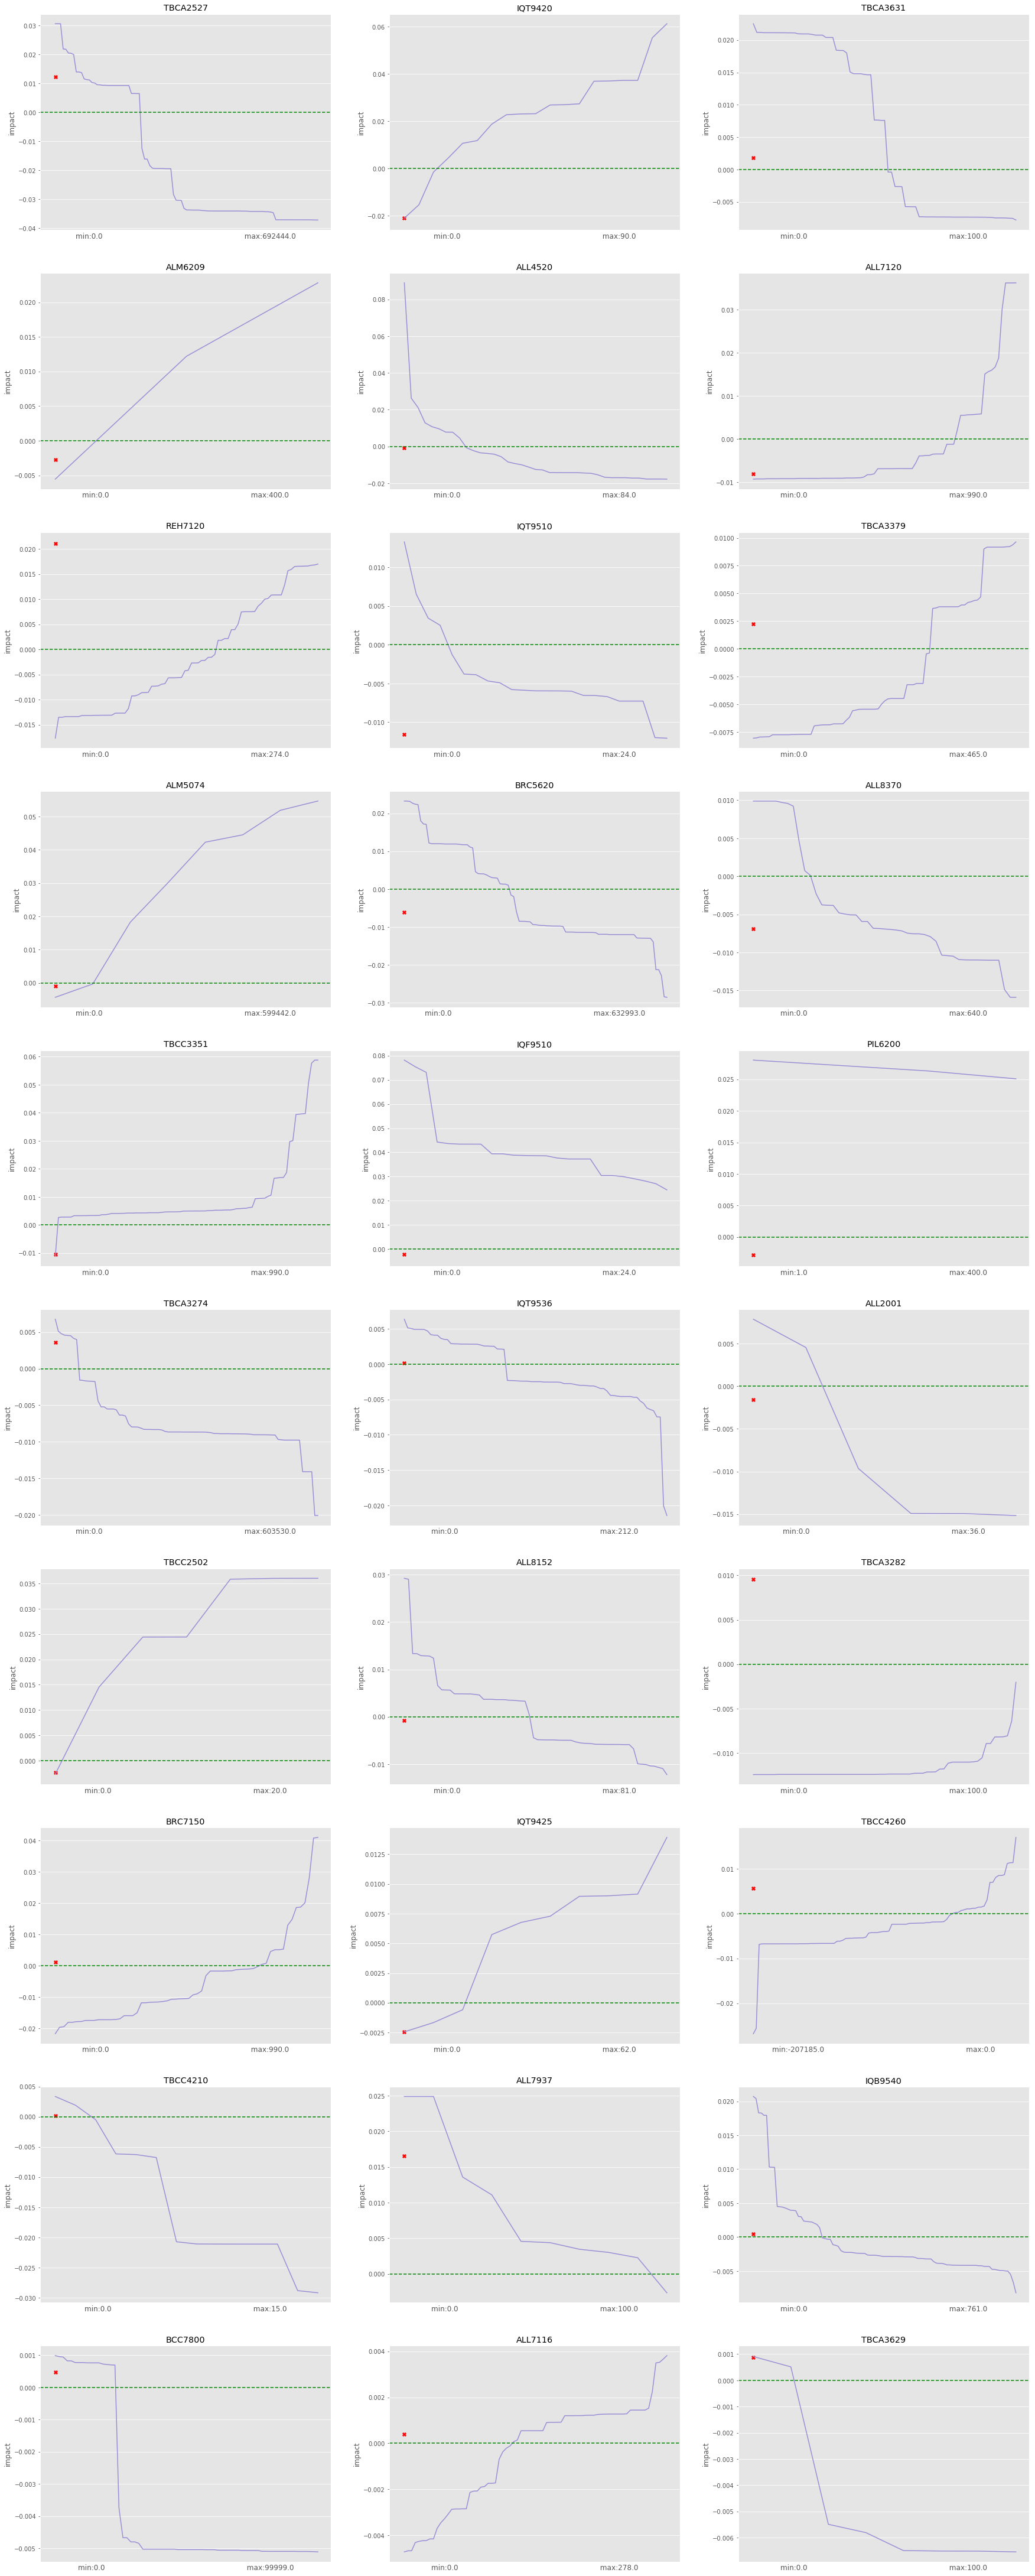

In [17]:
from _utilities import pdp
thin_pdp=pdp.pdp_dict(thin_model,thin_base, num_cut=100,sample_size=None,print_ind=True)

In [19]:
import pickle
file_name='./model_results/thin_model_pdp_dict_v12.p' 
pickle.dump(thin_pdp,open(file_name,'wb'))

### 4-2 Thick PDP

In [21]:
thick_base=base_train[base_train.thin_thick==0]
df_check=thick_base
print(len(thick_base))
p_eval.model_score_eval(df_check['24_month_bad90_flag'],df_check['model_pred'],df_check['vantage_v3_score'],decile=10,display=0)

2244349
model_pred AUC: 0.83362  KS: 50.9
vantage_v3_score AUC: 0.80433  KS: 46.7  #score missing: 0


In [22]:
print(len(thick_model.feature_name()))
np.array(thick_model.feature_name())

31


array(['REV5620', 'TBCA2527', 'BCC5620', 'BCA8370', 'ALL8325', 'TBCC2351',
       'REH7120', 'BCX7110', 'ALL8320', 'ALL4520', 'ALL7938', 'IQT9426',
       'IQT9510', 'IQT9427', 'IQT9420', 'ALL5072', 'ALL7340', 'ALL8160',
       'ALL8164', 'ALL8152', 'ALL7517', 'ALL7936', 'TBCC4502', 'TBCC3503',
       'TBCC2503', 'ALM6280', 'TBCA3275', 'ALL7519', 'ALM6200', 'ALL7518',
       'TBCC3205'], dtype='<U8')

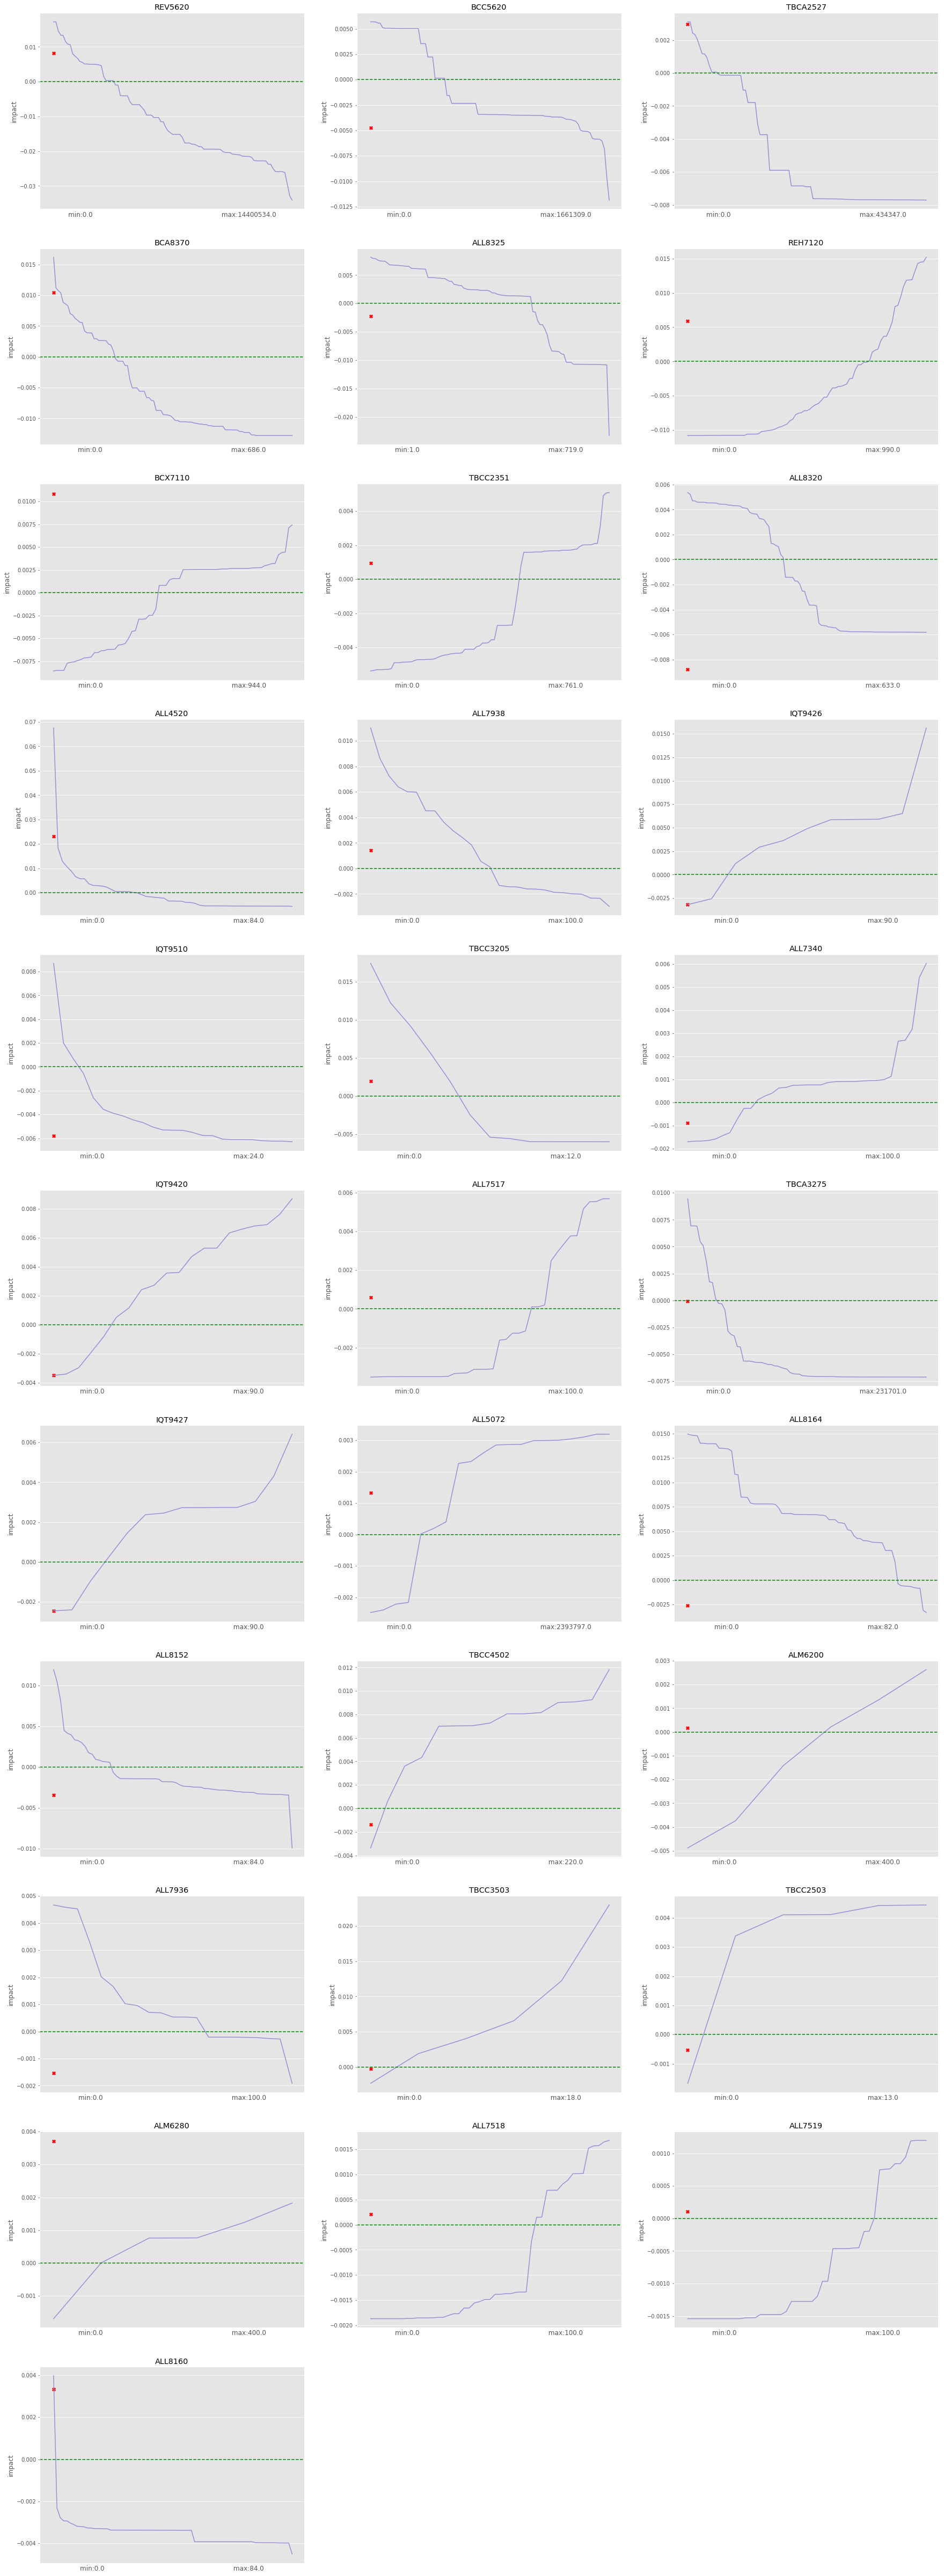

In [32]:
from _utilities import pdp
thick_pdp=pdp.pdp_dict(thick_model,thick_base, num_cut=100,sample_size=1000000,print_ind=True)

In [33]:
import pickle
file_name='./model_results/thick_model_pdp_dict_v12.p' 
pickle.dump(thick_pdp,open(file_name,'wb'))

#### Model Features and Description

In [24]:
thin_attr=thin_model.feature_name()
thick_attr=thick_model.feature_name()

In [25]:
attr_dict_desp=attrs_comibine[['field_name','description','length','long_description', 'valid_values','tag']]

In [26]:
attr_thin=pd.DataFrame()
attr_thin['description']=thin_model.feature_name()
attr_thin['importance']=thin_model.feature_importance(importance_type='gain',iteration=thin_model.best_iteration)
attr_thin.sort_values(by="importance",ascending=False,inplace=True)
attr_thin=attr_thin.merge(attr_dict_desp,how='left',on='description')
attr_thin['model_seg']='thin'

In [27]:
attr_thick=pd.DataFrame()
attr_thick['description']=thick_model.feature_name()
attr_thick['importance']=thick_model.feature_importance(importance_type='gain',iteration=thick_model.best_iteration)
attr_thick.sort_values(by="importance",ascending=False,inplace=True)
attr_thick=attr_thick.merge(attr_dict_desp,how='left',on='description')
attr_thick['model_seg']='thick'

In [28]:
attr_thin_thick=pd.concat([attr_thin,attr_thick],axis=0)[['model_seg','field_name','description','importance','tag','length',
                                                         'valid_values','long_description']]

In [29]:
attr_thin_thick.to_csv('attr_thin_thick_v12.csv',index=False)
attr_thin_thick

,model_seg,field_name,description,importance,tag,length,valid_values,long_description
0,thin,trended3d_tbca2527,TBCA2527,1.136029e+05,trended,9.0,0 - 999999990,"Average available credit amount over the last 6 months of open, or closed with a balance > $0 bankcard revolving and charge trade with the highest 6 month average balance, excluding derogatory trades, reported in the last 3 months"
1,thin,P13_IQT9420,IQT9420,4.813641e+04,New credit,2.0,0-90,Total number of inquiries (no deduplication)
2,thin,trended3d_tbca3631,TBCA3631,3.819764e+04,trended,3.0,0 - 110,"Payment ratio over the last 12 months of open, or closed with a balance > $0 bankcard revolving and charge trade with the highest 12 month average balance, excluding derogatory trades, reported in the last 2 months"
3,thin,P13_ALM6209,ALM6209,3.042125e+04,Payment history,3.0,0-400,Worst ever status on a trade including collections (excluding satisfied medical collections) and indeterminates
4,thin,P13_ALL4520,ALL4520,2.895147e+04,Payment history,2.0,0-90,"Longest consecutive months with a satisfactory balance activity status on trades, excluding collections and other unsatisfied derogatory including indeterminates"
5,thin,P13_ALL7120,ALL7120,2.847457e+04,Credit utilization,3.0,0-990,Maximum single balance to credit amount ratio on an open trade reported in the last 3 months with credit amount > $0
6,thin,P13_REH7120,REH7120,2.547446e+04,Credit utilization,3.0,0-990,"Maximum single balance to credit amount ratio on an open revolving trade reported in the last 3 months with credit amount > $0, excluding home equity line of credit trades"
7,thin,P13_IQT9510,IQT9510,2.344908e+04,New credit,4.0,0-9990,Number of months since the most recent inquiry (no deduplication)
8,thin,trended3d_tbca3379,TBCA3379,1.957407e+04,trended,3.0,0 - 990,"Average balance to credit amount ratio over the last 12 months of open, or closed with a balance > $0 bankcard revolving and charge trade with the highest 12 month average balance, excluding derogatory trades, reported in the last 3 months"
9,thin,P13_ALM5074,ALM5074,1.816386e+04,Payment history,9.0,0-999999990,Total balance on trades ever derogatory including non-medical collections


### dump model file as txt file

In [30]:
import pickle
file_name='./model_results/thick_model_v12.txt' 
pickle.dump(thick_model,open(file_name,'wb'))

In [31]:
file_name='./model_results/thin_model_v12.txt' 
pickle.dump(thin_model,open(file_name,'wb'))

In [3]:
import pickle
file_name2='./model_results/thin_model_pdp_dict_v12.p'
thin_pdp=pickle.load(open(file_name2,'rb'))

In [5]:
thin_pdp['IQF9510']

,attr_label,min,max,grid,pred,impact
0,1,0.0,0.0,0.0,0.193356,0.078161
1,2,1.0,1.0,1.0,0.190619,0.075425
2,3,2.0,2.0,2.0,0.188300,0.073105
3,4,3.0,3.0,3.0,0.159466,0.044271
4,5,4.0,4.0,4.0,0.158837,0.043642
5,6,5.0,5.0,5.0,0.158603,0.043409
6,7,6.0,6.0,6.0,0.158603,0.043409
7,8,7.0,7.0,7.0,0.158588,0.043393
8,9,8.0,8.0,8.0,0.154589,0.039394
9,10,9.0,9.0,9.0,0.154589,0.039394
